This project contains several python files. The FinalProject.ipynb file is the LSTM Model to predict the MFST(Microsoft). It will gernerate some analysis graphs and csv data files so that you can check the predicted values and how this model will affect the future possible stock prices. This file will start read stock prices from this date: 
msft_data = msft.history(start="2018-01-01", end="2023-05-20")
and it will predict next 150 days after the end date:
# Predict the next 150 days
forecast_days = 150
You can change the number to decide what part of data you wanna use and how long you want to predict.

The MSFT_UpToDate.py file will get the latest MFST stock prices in every 60 seconds. It will also create csv data file and chart so that you can see how the real stock prices goes. 

After these, if you want to run the website, you can run the run_notebook.py file. It will run a local server with FinalProjecy.html file and displayCSV.js file . 
After running, you can see the 
Serving HTTP on :: port 8000 (http://[::]:8000/) ...
Data updated at 2023-12-12 16:10:05.361028
::1 - - [12/Dec/2023 16:10:13] "GET /FinalProject.html HTTP/1.1" 304 -
::1 - - [12/Dec/2023 16:10:20] "GET /MSFT.csv HTTP/1.1" 200 -
::1 - - [12/Dec/2023 16:10:45] "GET /FinalProject.html HTTP/1.1" 304 -
::1 - - [12/Dec/2023 16:10:45] "GET /MSFT.png HTTP/1.1" 200 -
::1 - - [12/Dec/2023 16:10:45] "GET /MSFT.csv HTTP/1.1" 304 -
Data updated at 2023-12-12 16:11:06.050162
You can see the Data updated in every 60 seconds.
Then you can click this link: http://localhost:8000/FinalProject.html
to check the website.
Also, when you are tyring to runing multiple times after the data is updated by changing some numbers, I recommand you to use Incognito mode Browser. It will give you the updated data.

In [99]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt


In [81]:
# Load MSFT data
msft = yf.Ticker("MSFT")
msft_data = msft.history(start="2018-01-01", end="2023-05-20")
msft_data['Mid'] = (msft_data['High'] + msft_data['Low'])/2


In [82]:
# Define the RSI calculation function
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [83]:
# Create a copy of the data for correlation analysis
correlation_data = msft_data.copy()
# Calculate mid prices for the correlation data
# correlation_data['Mid'] = (correlation_data['High'] + correlation_data['Low']) / 2.0
# Check the total size of msft_data
total_data_points = msft_data.shape[0]
print("Total number of data points:", total_data_points)

Total number of data points: 1355


In [84]:
# Dynamic split index based on a percentage of the dataset
split_percentage = 0.8  # for example, 80% for training and 20% for testing
split_index = int(msft_data.shape[0] * split_percentage)

mid_prices = msft_data['Mid'].values
train_data = mid_prices[:split_index]
test_data = mid_prices[split_index:]

# Ensure that train and test data sets are non-empty
if len(train_data) == 0:
    raise ValueError("Training data set is empty.")
if len(test_data) == 0:
    raise ValueError("Test data set is empty.")

# Print the sizes
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1084
Test data size: 271


In [85]:
# Scaling the mid prices
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Scale the training data
train_data = scaler.fit_transform(train_data).reshape(-1)

# Check if test_data is not empty before transforming
if test_data.size > 0:
    # Transform the test data
    test_data = scaler.transform(test_data).reshape(-1)
else:
    raise ValueError("Test data set is empty after reshaping.")

In [86]:
# Exponential Moving Average Smoothing for training data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Combining train and test data for visualization
all_mid_data = np.concatenate([train_data, test_data], axis=0)

# Standard Averaging Predictions
window_size = 100
N = train_data.size
std_avg_predictions = []
mse_errors = []

for pred_idx in range(window_size, N):
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx])**2)

print('MSE error for standard averaging: %.5f' % (0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.00188


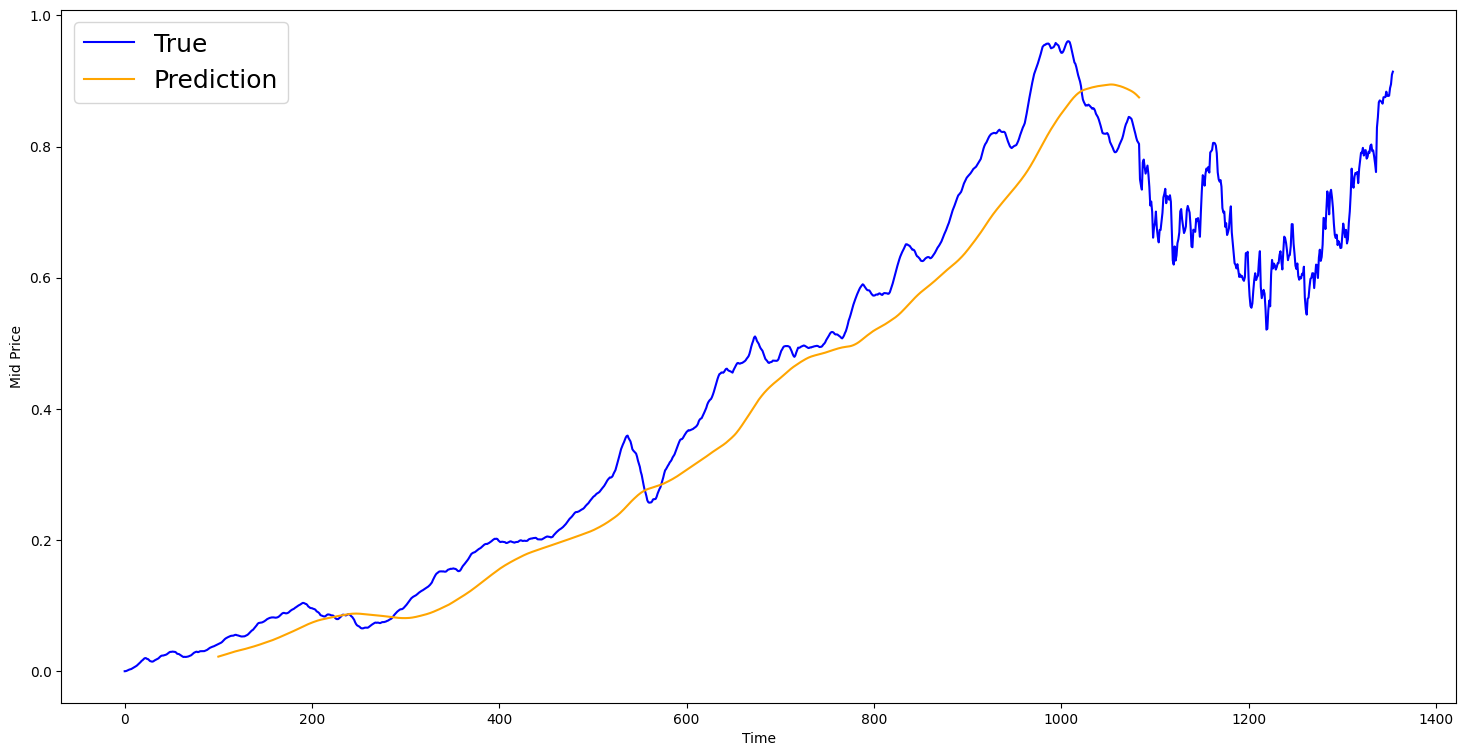

In [87]:
# Plotting the standard averaging predictions
plt.figure(figsize=(18, 9))
plt.plot(range(msft_data.shape[0]), all_mid_data, color='b', label='True')
plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='Prediction')
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.savefig('standard_averaging_predictions.png')
plt.show()

In [88]:
# Calculate additional features like 'SMA_50', 'SMA_200', 'RSI' for the correlation data
correlation_data['SMA_50'] = correlation_data['Close'].rolling(window=50).mean()
correlation_data['SMA_200'] = correlation_data['Close'].rolling(window=200).mean()
correlation_data['RSI'] = compute_RSI(correlation_data['Close'])

# Drop rows with NaN values in correlation data
correlation_data.dropna(inplace=True)

# Select relevant features for the correlation matrix
features_for_correlation = ['Open', 'High', 'Low', 'Close', 'SMA_50', 'SMA_200', 'RSI']
correlation_data = correlation_data[features_for_correlation]

# Calculate the correlation matrix
corr_matrix = correlation_data.corr()


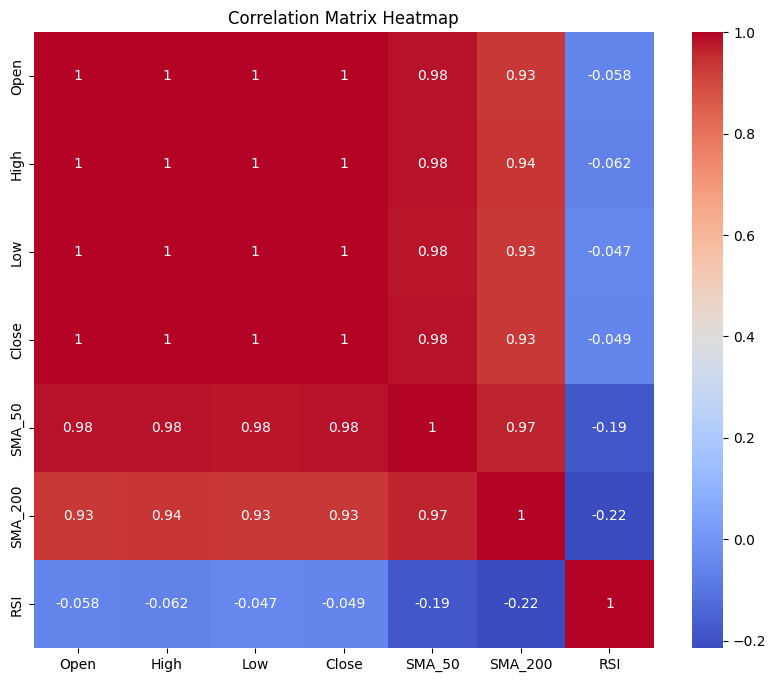

In [89]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.savefig('MSFT_Correlation_Matrix.png')
plt.show()


In [90]:
# Calculate Simple Moving Averages (SMA) and Relative Strength Index (RSI)
msft_data['SMA_50'] = msft_data['Close'].rolling(window=50).mean()
msft_data['SMA_200'] = msft_data['Close'].rolling(window=200).mean()
msft_data['RSI'] = compute_RSI(msft_data['Close'])

# Drop rows with NaN values (due to SMA and RSI calculations)
msft_data.dropna(inplace=True)


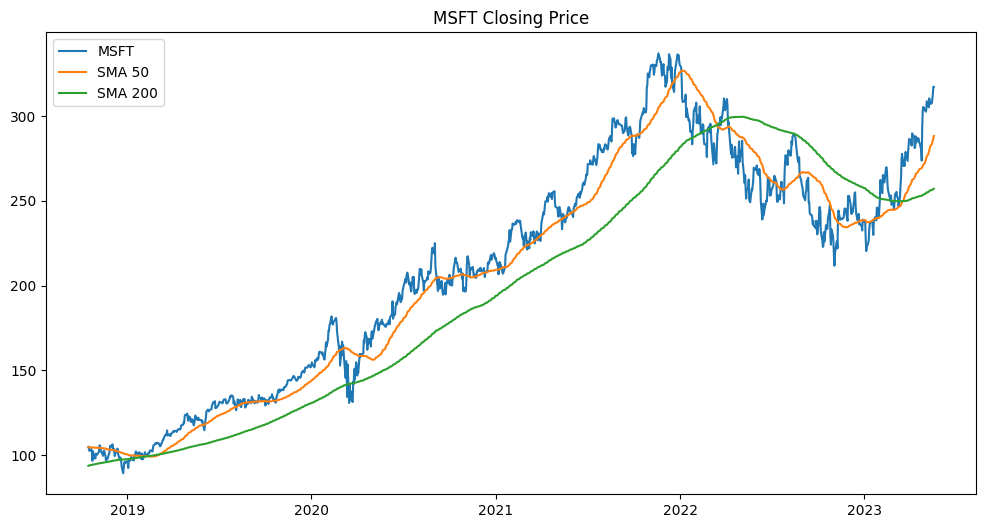

In [91]:
# Show the Simple Moving Averages and Relative Strength Index in a plot
plt.figure(figsize=(12, 6))
plt.plot(msft_data['Close'], label='MSFT')
plt.plot(msft_data['SMA_50'], label='SMA 50')
plt.plot(msft_data['SMA_200'], label='SMA 200')
plt.legend(loc='upper left')
plt.title('MSFT Closing Price')
plt.savefig('MSFT_SMA.png')
plt.show()


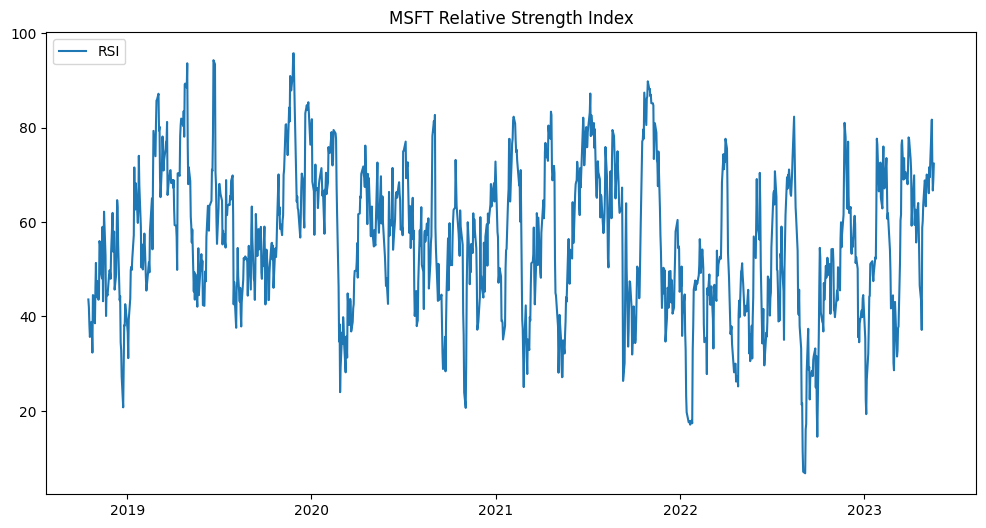

In [92]:
# Show the Relative Strength Index in a plot
plt.figure(figsize=(12, 6))
plt.plot(msft_data['RSI'], label='RSI')
plt.legend(loc='upper left')
plt.title('MSFT Relative Strength Index')
plt.savefig('MSFT_RSI.png')
plt.show()


In [93]:
# Select the features to scale, excluding 'Mid'
features = ['Open', 'High', 'Low', 'Close', 'SMA_50', 'SMA_200', 'RSI']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msft_data[features])


In [94]:
# Create a dataset for LSTM, without 'Mid'
def create_dataset(dataset, time_step=100):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Include all features except 'Mid'
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predicting all features at the next time step
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(scaled_data, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))  # Reshape for LSTM


In [95]:
# Define the LSTM model with dropout and regularization
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(features)))  

# Create an optimizer instance with a specified learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X, Y, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
27/27 [==============================] - 5s 88ms/step - loss: 0.0756 - val_loss: 0.0105
Epoch 2/20
27/27 [==============================] - 2s 58ms/step - loss: 0.0188 - val_loss: 0.0088
Epoch 3/20
27/27 [==============================] - 2s 60ms/step - loss: 0.0148 - val_loss: 0.0069
Epoch 4/20
27/27 [==============================] - 2s 60ms/step - loss: 0.0138 - val_loss: 0.0072
Epoch 5/20
27/27 [==============================] - 2s 58ms/step - loss: 0.0123 - val_loss: 0.0078
Epoch 6/20
27/27 [==============================] - 2s 60ms/step - loss: 0.0117 - val_loss: 0.0059
Epoch 7/20
27/27 [==============================] - 2s 56ms/step - loss: 0.0107 - val_loss: 0.0088
Epoch 8/20
27/27 [==============================] - 2s 59ms/step - loss: 0.0111 - val_loss: 0.0051
Epoch 9/20
27/27 [==============================] - 2s 57ms/step - loss: 0.0092 - val_loss: 0.0043
Epoch 10/20
27/27 [==============================] - 2s 58ms/step - loss: 0.0097 - val_loss: 0.0042
Epoch 11/

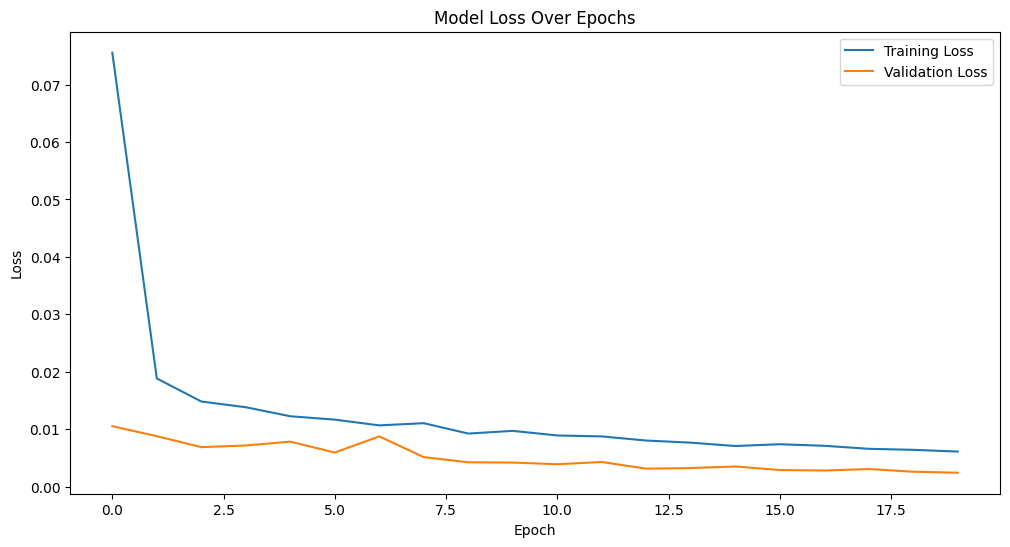

In [96]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('MSFT_Loss.png')
plt.show()


In [97]:
# Prepare the input for prediction
last_days = scaled_data[-time_step:]
last_days = last_days.reshape(1, time_step, len(features))
# Predict the next 150 days
forecast_days = 150
forecast = []
for _ in range(forecast_days):
    pred = model.predict(last_days)
    print(pred)  # Add this line to debug
    forecast.append(pred[0, 0])
    new_row = np.append(last_days[0, -1, 1:], pred[0, 0])
    last_days = np.append(last_days[:, 1:, :], [new_row.reshape(1, len(features))], axis=1)
print(forecast)
if forecast:
    # Create a placeholder array with the same shape as the original scaled data
    placeholder = np.zeros((len(forecast), scaled_data.shape[1]))
    
    # Replace the first column (assuming it's the closing price) with the predictions
    placeholder[:, 0] = np.array(forecast).flatten()
    
    # Inverse transform the complete array
    inverse_transformed = scaler.inverse_transform(placeholder)

    # Extract only the closing price predictions
    forecast = inverse_transformed[:, 0]
else:
    print("Forecast list is empty. Check model predictions.")
# Save and display forecast
forecast_df = pd.DataFrame(forecast, columns=['Forecast'])
forecast_df.to_csv('MSFT_forecast.csv', index=False)

1/1 [==============================] - 1s 619ms/step
[[0.90398693 0.904957   0.8896068  0.90424204 0.86681986 0.807292
  0.6581506 ]]
1/1 [==============================] - 0s 39ms/step
[[0.9128447  0.9141502  0.89865285 0.9124028  0.8710718  0.80725646
  0.680985  ]]
1/1 [==============================] - 0s 25ms/step
[[0.9175226  0.9193772  0.90273523 0.91782975 0.87166053 0.8061582
  0.70502627]]
1/1 [==============================] - 0s 27ms/step
[[0.91917765 0.9194849  0.9017536  0.91896224 0.8686502  0.8044027
  0.7233974 ]]
1/1 [==============================] - 0s 30ms/step
[[0.91547275 0.91478634 0.8963236  0.9159681  0.86331886 0.8020552
  0.7351249 ]]
1/1 [==============================] - 0s 29ms/step
[[0.9123224  0.910115   0.89182705 0.9132882  0.8595356  0.80106235
  0.74440616]]
1/1 [==============================] - 0s 26ms/step
[[0.90860426 0.90467846 0.88851833 0.91008705 0.8559386  0.8022189
  0.7471318 ]]
1/1 [==============================] - 0s 27ms/step
[[0.9089

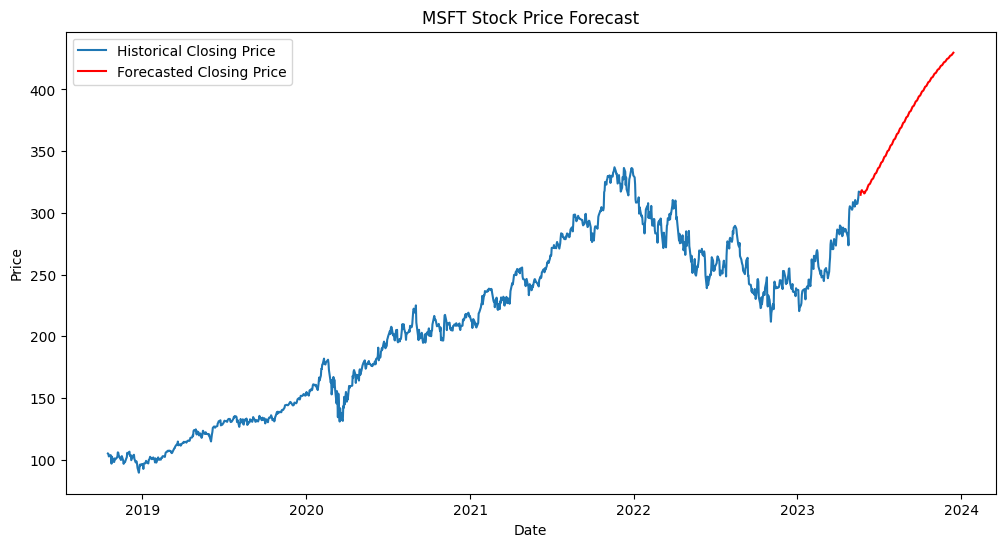

In [98]:
# Plotting the forecast
last_date = msft_data.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=len(forecast) + 1, freq='B')[1:]  # Skip the first date
plt.figure(figsize=(12,6))
plt.plot(msft_data['Close'], label='Historical Closing Price')
plt.plot(forecast_dates, forecast, label='Forecasted Closing Price', color='red')
plt.title('MSFT Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('MSFT_Forecast.png')
plt.show()
# Save MSFT forecast to CSV file
msft_forecast = pd.DataFrame({'Date': forecast_dates, 'Close': forecast})
msft_forecast.to_csv('MSFT_Forecast.csv', index=False)